<h2>Network Data Analysis - Coursework 2</h2>

<h3>Task B: Invest Road Accidents on the Road Network</h3>

Note: The environment is conda 23.11.0 and is configured according to the guidance of NDA github page

In [1]:
%%capture
%run -i Task_A.ipynb

<h4>Importing Libraries</h4>

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame

import warnings
warnings.simplefilter('ignore')

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import shapely
from shapely.geometry import Point, MultiPoint, LineString
from shapely.ops import nearest_points

from pointpats import PointPattern
from pointpats import PoissonPointProcess as ppp_csr
from pointpats.window import poly_from_bbox, as_window, Window, to_ccf
import pointpats.quadrat_statistics as qs

import folium
from folium import plugins


import spaghetti
import esda

<h4>Dataframe and network selected in Task A</h4>

In [3]:
# area selected in Task A
selected_leeds_rta_area

,geometry
0,"POLYGON ((-1.54524 53.79314, -1.54615 53.79321, -1.54635 53.79324, -1.54687 53.79332, -1.54778 53.80224, -1.54761 53.80961, -1.54746 53.81018, -1.54480 53.81022, -1.52807 53.81023, -1.52381 53.80957, -1.51931 53.80673, -1.51877 53.80186, -1.51872 53.79443, -1.52081 53.79380, -1.52338 53.79330, -1.53077 53.79322, -1.53621 53.79316, -1.54524 53.79314))"


In [4]:
# full geodataframe
leeds_rta_geodata_df.head(3)

,Reference Number,Grid Ref: Easting,Longitude,Grid Ref: Northing,Latitude,geometry,Number of Vehicles,Expr1,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,1st Road Class & No,Accident Fields_Reference Number,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No
0,2181280,418241,-1.724035,442351,53.877056,POINT (-1.72403 53.87706),2,Leeds 2016,08/01/2016,1905,A,Dry,Darkness: street lights present and lit,Fine without high winds,Driver or rider,Serious,Male,38,Motorcycle over 500cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2191037,424993,-1.622101,432898,53.791816,POINT (-1.62210 53.79182),2,Leeds 2016,09/01/2016,1615,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,Driver or rider,Slight,Female,50,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2CQ0870,431159,-1.528156,436397,53.822933,POINT (-1.52816 53.82293),2,Leeds 2016,15/01/2016,1645,Unclassified,Dry,Daylight: street lights present,Fine without high winds,Driver or rider,Slight,Male,26,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# selected area geodataframe
selected_leeds_rta_points.head(3)

,Reference Number,Grid Ref: Easting,Longitude,Grid Ref: Northing,Latitude,geometry,Number of Vehicles,Expr1,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,1st Road Class & No,Accident Fields_Reference Number,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No
32,3161098,429959,-1.546681,433326,53.795402,POINT (-1.54668 53.79540),2,Leeds 2016,06/01/2016,1723,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,Driver or rider,Slight,Male,39,Pedal cycle,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,3191206,430876,-1.532668,434256,53.803707,POINT (-1.53267 53.80371),2,Leeds 2016,09/01/2016,1810,A,Wet / Damp,Darkness: street lights present and lit,Raining without high winds,Driver or rider,Slight,Male,23,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,3191206,430876,-1.532668,434256,53.803707,POINT (-1.53267 53.80371),2,Leeds 2016,09/01/2016,1810,A,Wet / Damp,Darkness: street lights present and lit,Raining without high winds,Driver or rider,Slight,Female,29,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# road network selected in Task A
selected_leeds_rta_network

<h4>Task B - 1</h4>

<b>1.1 Compare with Complete Spatial Randomness (CSR)</b>

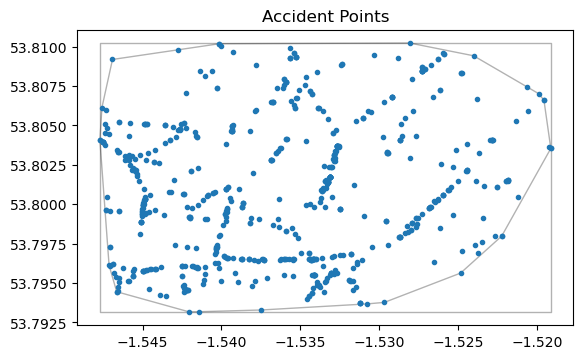

In [7]:
points = [Point(xy) for xy in zip(selected_leeds_rta_points.geometry.x, selected_leeds_rta_points.geometry.y)]
point_array = np.array([(point.x, point.y) for point in points])

pp_accident = PointPattern(point_array)

pp_accident.plot(window=True, hull=True, title='Accident Points')

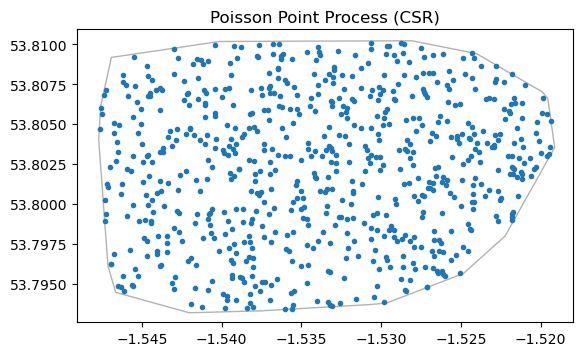

In [8]:
multi_point = MultiPoint(points)
convex_hull = multi_point.convex_hull
convex_hull_vertices = list(convex_hull.exterior.coords)
window = Window(convex_hull_vertices)

pp = ppp_csr(window, len(selected_leeds_rta_points), 1, asPP=True).realizations[0] 
pp.plot(window=True, title='Poisson Point Process (CSR)')


<Axes: title={'center': 'Quadrat Count'}>

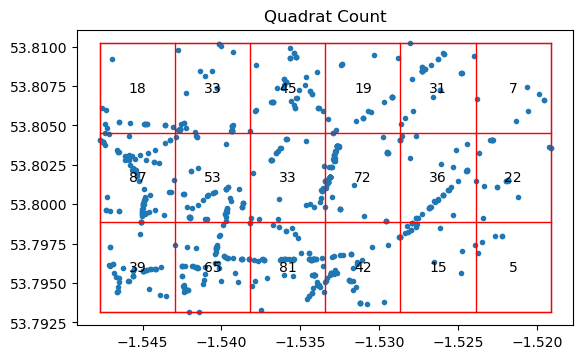

In [9]:
q_r_accident = qs.QStatistic(pp_accident,shape= "rectangle",nx = 6, ny = 3)
q_r_accident.plot()

In [10]:
print('Chi-squared test statistic for the observed point pattern is: '+ str(q_r_accident.chi2)) 
print('Degree of freedom is: '+str(q_r_accident.df)) 
print('P-valus for Chi-squared test statistic is: '+str.format('{0:.6f}', q_r_accident.chi2_pvalue)) 

Chi-squared test statistic for the observed point pattern is: 258.7325746799431
Degree of freedom is: 17
P-valus for Chi-squared test statistic is: 0.000000


Since the  p -value based on the analytical  χ2  distribution (degree of freedom = 17) is 0.000000, much smaller than 0.05. We might reject the null hypothesis of being a CSR process.

<b>1.2 Heat map</b>

In [11]:
# latitude and longitude should be float type
selected_leeds_rta_points['lat'] = selected_leeds_rta_points['Latitude'].astype(float)
selected_leeds_rta_points['lon'] = selected_leeds_rta_points['Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = selected_leeds_rta_points[['lat', 'lon']]
heat_df = heat_df.dropna(axis=0, subset=['lat','lon'])

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['lon']] for index, row in heat_df.iterrows()]

center_point = [most_rta_latitude, most_rta_longitude]
heatmap_map = folium.Map(center_point, zoom_start=15, width='100%', height='100%')

# Plot it on the map
hm=plugins.HeatMap(heat_data)
heatmap_map.add_child(hm)

In [12]:
ox.plot_graph_folium(selected_leeds_rta_network, graph_map=heatmap_map, popup_attribute='name', edge_width=2, zoom_start=15)


In [13]:
# Save the map
# heatmap_map.save('heatmap.html')

<b>1.3 Raod network with accident points</b>

In [14]:
list(selected_leeds_rta_network.nodes(data=True))[0:10]

[(611055, {'y': 53.7934435, 'x': -1.5350094, 'street_count': 3}),
 (611057, {'y': 53.7950006, 'x': -1.533947, 'street_count': 3}),
 (643851, {'y': 53.7956485, 'x': -1.5326979, 'street_count': 4}),
 (643907, {'y': 53.7983902, 'x': -1.5360412, 'street_count': 3}),
 (643911, {'y': 53.7964981, 'x': -1.5348803, 'street_count': 3}),
 (643914, {'y': 53.7965251, 'x': -1.5343196, 'street_count': 4}),
 (643929, {'y': 53.7950089, 'x': -1.5381171, 'street_count': 3}),
 (643930, {'y': 53.7951126, 'x': -1.540124, 'street_count': 3}),
 (643931,
  {'y': 53.7949163,
   'x': -1.5411975,
   'highway': 'traffic_signals',
   'street_count': 3}),
 (643933, {'y': 53.7944708, 'x': -1.5422822, 'street_count': 4})]

In [15]:
list(selected_leeds_rta_network.edges(data=True))[0:3]

[(611055,
  342626322,
  {'osmid': [4372315, 4326732],
   'bridge': 'yes',
   'lanes': '3',
   'ref': 'A653',
   'name': ['Crown Point Road', 'Crown Point Bridge'],
   'highway': 'secondary',
   'maxspeed': '30 mph',
   'oneway': False,
   'reversed': False,
   'length': 95.57900000000001,
   'geometry': <LINESTRING (-1.535 53.793, -1.535 53.794, -1.535 53.794, -1.535 53.794, -1....>}),
 (611057,
  6047609602,
  {'osmid': 229127796,
   'oneway': True,
   'lanes': '4',
   'ref': 'A61',
   'name': 'East Street',
   'highway': 'trunk',
   'maxspeed': '30 mph',
   'reversed': False,
   'length': 17.615}),
 (643851,
  1020737601,
  {'osmid': 87797769,
   'oneway': True,
   'lanes': '3',
   'ref': 'A653',
   'name': 'Crown Point Road',
   'highway': 'trunk_link',
   'maxspeed': '30 mph',
   'reversed': False,
   'length': 7.979})]

In [16]:
# get the locations of the points
x_values = nx.get_node_attributes(selected_leeds_rta_network, 'x')
y_values = nx.get_node_attributes(selected_leeds_rta_network, 'y')

# add the missing geometries
graph_with_geometries = list(selected_leeds_rta_network.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])
        
graph_with_geometries[0:3]

[(611055,
  342626322,
  {'osmid': [4372315, 4326732],
   'bridge': 'yes',
   'lanes': '3',
   'ref': 'A653',
   'name': ['Crown Point Road', 'Crown Point Bridge'],
   'highway': 'secondary',
   'maxspeed': '30 mph',
   'oneway': False,
   'reversed': False,
   'length': 95.57900000000001,
   'geometry': <LINESTRING (-1.535 53.793, -1.535 53.794, -1.535 53.794, -1.535 53.794, -1....>}),
 (611057,
  6047609602,
  {'osmid': 229127796,
   'oneway': True,
   'lanes': '4',
   'ref': 'A61',
   'name': 'East Street',
   'highway': 'trunk',
   'maxspeed': '30 mph',
   'reversed': False,
   'length': 17.615,
   'geometry': <LINESTRING (-1.534 53.795, -1.534 53.795)>}),
 (643851,
  1020737601,
  {'osmid': 87797769,
   'oneway': True,
   'lanes': '3',
   'ref': 'A653',
   'name': 'Crown Point Road',
   'highway': 'trunk_link',
   'maxspeed': '30 mph',
   'reversed': False,
   'length': 7.979,
   'geometry': <LINESTRING (-1.533 53.796, -1.533 53.796)>})]

In [17]:
# drop the start and end nodes
road_lines = [x[2] for x in graph_with_geometries]
# create geodataframe
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe.head(3)

,osmid,bridge,lanes,ref,name,highway,maxspeed,oneway,reversed,length,geometry,junction,width,access,tunnel
0,"[4372315, 4326732]",yes,3,A653,"[Crown Point Road, Crown Point Bridge]",secondary,30 mph,False,False,95.579,"LINESTRING (-1.53501 53.79344, -1.53483 53.79366, -1.53466 53.79387, -1.53460 53.79394, -1.53446 53.79410, -1.53436 53.79421)",NaN,NaN,NaN,NaN
1,229127796,NaN,4,A61,East Street,trunk,30 mph,True,False,17.615,"LINESTRING (-1.53395 53.79500, -1.53408 53.79514)",NaN,NaN,NaN,NaN
2,87797769,NaN,3,A653,Crown Point Road,trunk_link,30 mph,True,False,7.979,"LINESTRING (-1.53270 53.79565, -1.53260 53.79569)",NaN,NaN,NaN,NaN


In [18]:
# create the spaghetti network
leeds_point_graph = spaghetti.Network(in_data = roads_geodataframe)

<Axes: >

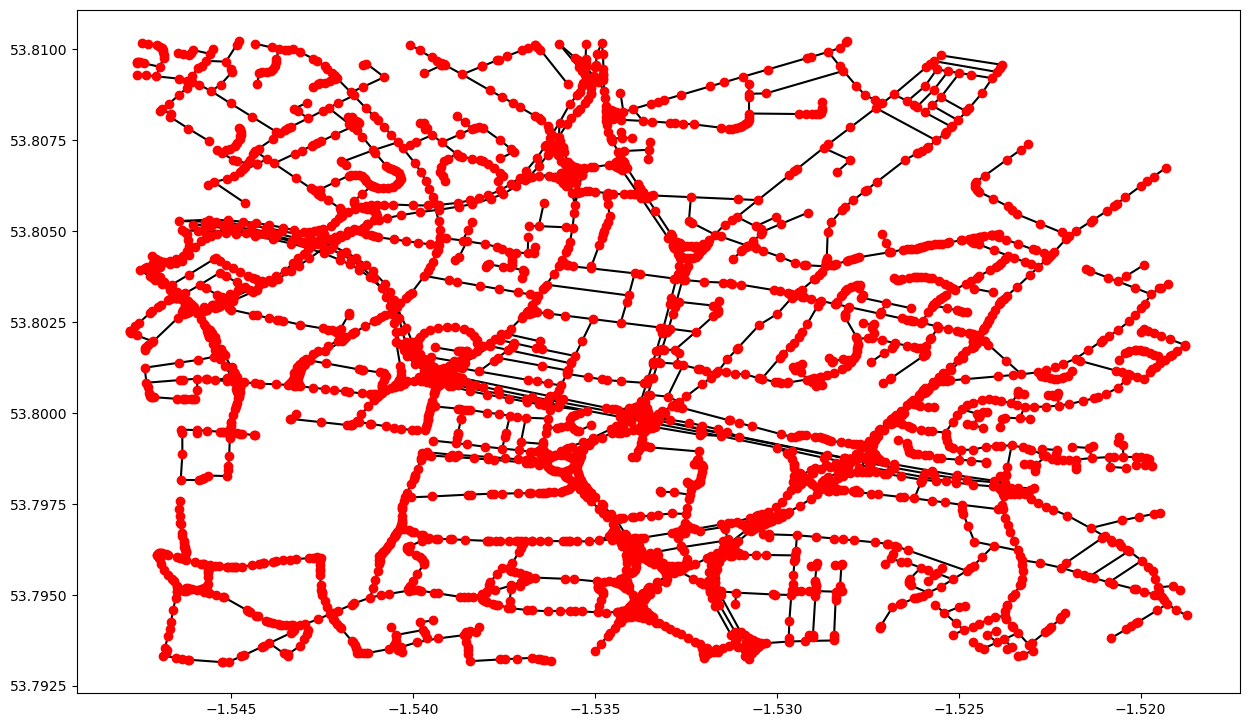

In [19]:
# plot the network
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_point_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

In [20]:
# get the snapped points
# leeds_accidents = selected_leeds_rta_points[selected_leeds_rta_points.geometry.within(selected_leeds_polygon)]
leeds_accidents = GeoDataFrame(geometry=selected_leeds_rta_points['geometry'].copy())
leeds_accidents.head(5)

,geometry
32,POINT (-1.54668 53.79540)
62,POINT (-1.53267 53.80371)
63,POINT (-1.53267 53.80371)
78,POINT (-1.54247 53.79483)
89,POINT (-1.54426 53.80270)


In [21]:
# snap the accident points to the network
leeds_point_graph.snapobservations(leeds_accidents, 'accidents', attribute=True)

print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_point_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_point_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

observation 1
true coords:	(-1.5466814847068018, 53.79540211968999)
snapped coords:	(-1.5466446145616508, 53.795442664179504)


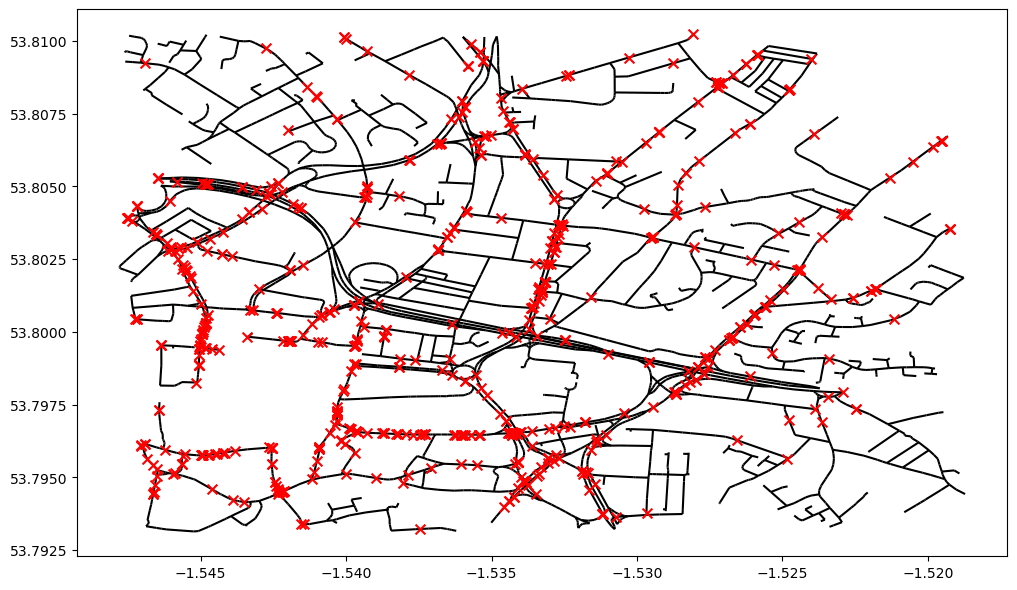

In [22]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped accident locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(
    leeds_point_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

<Axes: >

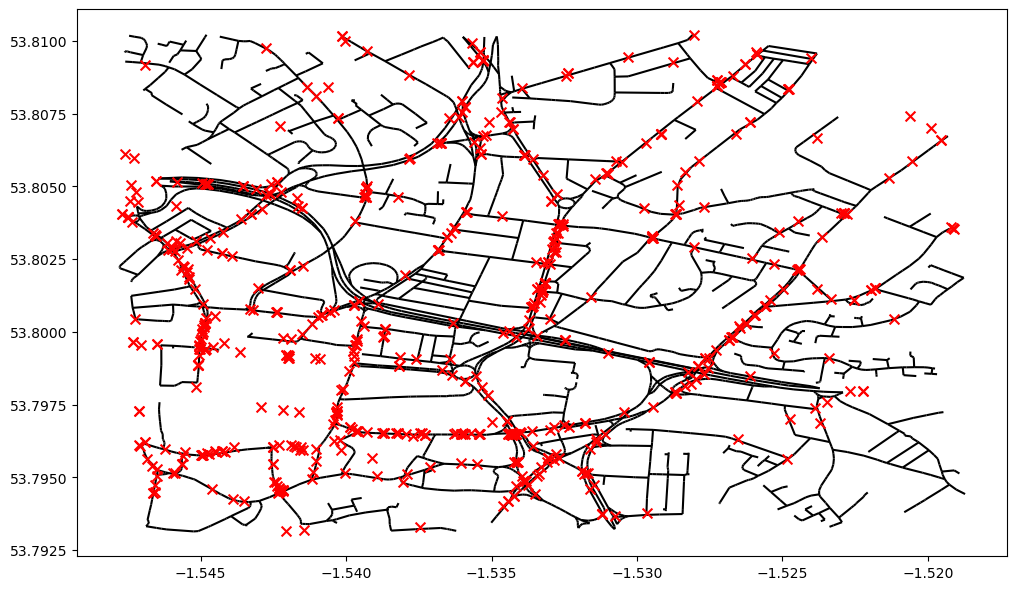

In [23]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the non-snapped (real) crime locations to plot on the net
observed_accidents=spaghetti.element_as_gdf(
    leeds_point_graph, pp_name='accidents', snapped=False)

# Plot these on the road network
observed_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)


<h4>Task B - 2</h4>

<b>2.1 K function</b>

In [24]:
kres = leeds_point_graph.GlobalAutoK(
    leeds_point_graph.pointpatterns["accidents"],
    nsteps=50, permutations=100
)

In [25]:
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

Density of points in the network (lambda): 883.4436129919295


In [26]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

Distances at which density is measured:
[0.         0.00075205 0.00150411 0.00225616 0.00300821 0.00376026
 0.00451232 0.00526437 0.00601642 0.00676848 0.00752053 0.00827258
 0.00902463 0.00977669 0.01052874 0.01128079 0.01203285 0.0127849
 0.01353695 0.01428901 0.01504106 0.01579311 0.01654516 0.01729722
 0.01804927 0.01880132 0.01955338 0.02030543 0.02105748 0.02180953
 0.02256159 0.02331364 0.02406569 0.02481775 0.0255698  0.02632185
 0.0270739  0.02782596 0.02857801 0.02933006 0.03008212 0.03083417
 0.03158622 0.03233828 0.03309033 0.03384238 0.03459443 0.03534649
 0.03609854 0.03685059]


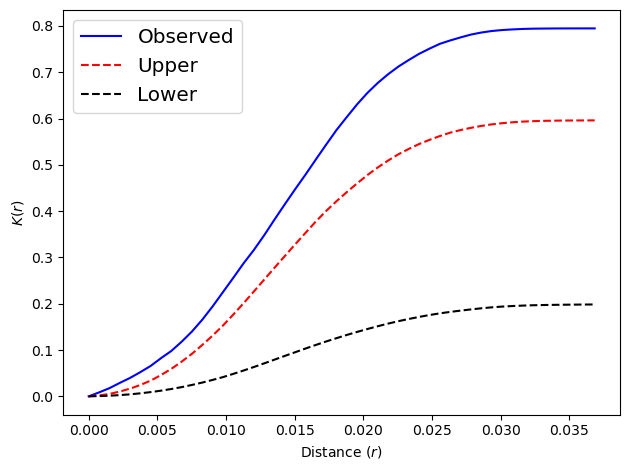

In [27]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

At all distances and increasing as distance increases, the points are more clustered than would be expected (CSR).

<b>2.2 Spatial Autocorrelation (Moran's I)</b>

In [28]:
# Get snapped point pattern
pointpat = leeds_point_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the accident count on that edge
counts = leeds_point_graph.count_per_link(pointpat.obs_to_arc, graph=False)

# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_point_graph.w_network

# Get the edges included in the weights matrix
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. for index, edge in enumerate(edges)]

In [29]:
moran = esda.moran.Moran(values, weights)
moran.I

0.11315497849498632

In [30]:
moran.EI

-0.00026469031233456857

In [31]:
moran.p_sim

0.001

Text(0.5, 0, "Moran's I")

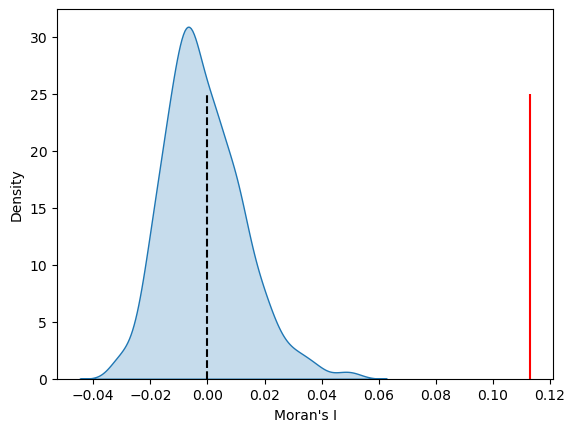

In [32]:
# plot Moran's I
sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 25, color='r', label='Moran\'s I')
plt.vlines(moran.EI, 0, 25, color='k', linestyle='--', label='Expected Moran\'s I')
plt.xlabel('Moran\'s I')

The results suggest that we have to regect H0 that road accidents follow CSR.

<h4>Task B - 3</h4>

In [33]:
roads_geodataframe.set_crs(epsg=4326, inplace=True).head(3)

,osmid,bridge,lanes,ref,name,highway,maxspeed,oneway,reversed,length,geometry,junction,width,access,tunnel
0,"[4372315, 4326732]",yes,3,A653,"[Crown Point Road, Crown Point Bridge]",secondary,30 mph,False,False,95.579,"LINESTRING (-1.53501 53.79344, -1.53483 53.79366, -1.53466 53.79387, -1.53460 53.79394, -1.53446 53.79410, -1.53436 53.79421)",NaN,NaN,NaN,NaN
1,229127796,NaN,4,A61,East Street,trunk,30 mph,True,False,17.615,"LINESTRING (-1.53395 53.79500, -1.53408 53.79514)",NaN,NaN,NaN,NaN
2,87797769,NaN,3,A653,Crown Point Road,trunk_link,30 mph,True,False,7.979,"LINESTRING (-1.53270 53.79565, -1.53260 53.79569)",NaN,NaN,NaN,NaN


In [34]:
# check the crs, it should be the same as the roads_geodataframe
leeds_accidents.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [35]:
ntw = spaghetti.Network(in_data=roads_geodataframe)
leeds_accidents

# capture the accidents on the network
ntw.snapobservations(leeds_accidents, 'accidents', attribute=True)

# calculate the distance to the nearest vertex
points_pattern = ntw.pointpatterns['accidents']

obs_to_vertex = points_pattern.obs_to_vertex
dist_to_nearest_vertex = {obs: min(dist.values()) for obs, dist in points_pattern.dist_to_vertex.items()}

distances = list(dist_to_nearest_vertex.values())
average_distance = sum(distances) / len(distances)

print(f"The average distance to the nearest vertex: {average_distance}")

The average distance to the nearest vertex: 6.215251621172554e-05


The distance is really small, which may indicate that accidents are more likely to happen near the intersection. 

Then we use ratios (distance/road_lenth) to check the result and visualize it. If most of the ratios are close to 0.5, accidents are more likely to happen in the middle of the roads. On the contrary, if most of the ratios are close to 0, accidents are more likely to happen near the intersection. 

In [36]:
distance_ratios = []

for accident in leeds_accidents.geometry:
    # Find the nearest road
    nearest_road = roads_geodataframe.distance(accident).idxmin()
    road_line = roads_geodataframe.geometry.iloc[nearest_road]
    
    # calculate the distance to the nearest point on the road
    nearest_point = nearest_points(accident, road_line)[1]
    dist_to_nearest_point = accident.distance(nearest_point)
    
    # total length of the road
    total_length = road_line.length
    
    # avoid division by zero
    if total_length == 0:
        continue
    
    ratio = dist_to_nearest_point / total_length
    ratio = min(ratio, 1)
    distance_ratios.append(ratio)

print('The mean of the distance ratio: ', np.mean(distance_ratios))

The mean of the distance ratio:  0.07648654298429383


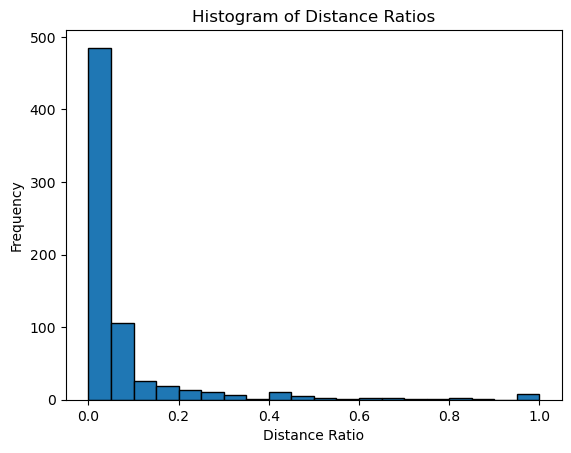

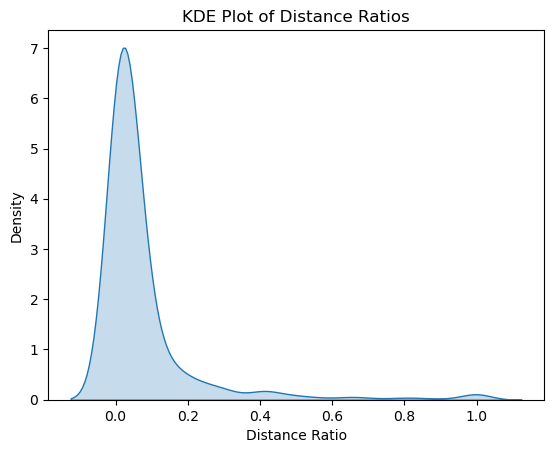

In [37]:
# histogram
plt.hist(distance_ratios, bins=20, edgecolor='black')
plt.title('Histogram of Distance Ratios')
plt.xlabel('Distance Ratio')
plt.ylabel('Frequency')
plt.show()

# KDE plot
sns.kdeplot(distance_ratios, shade=True)
plt.title('KDE Plot of Distance Ratios')
plt.xlabel('Distance Ratio')
plt.ylabel('Density')
plt.show()

Most of the values are close to 0, so accidents are more likely to happen near the intersection.